## Comparacion de SVM y una NN de resultados de clasificacion a partir de datos aumentados por oversampling de la categoria minoritaria. 

In [306]:
import pandas as pd
import numpy as np

df=pd.read_csv('processedFlair.csv')
df.set_index('Id', inplace=True)
df

,Mean/Image-original/diagnostics,Maximum/Image-original/diagnostics,VoxelNum/Mask-original/diagnostics,VolumeNum/Mask-original/diagnostics,10Percentile/firstorder/original,90Percentile/firstorder/original,Energy/firstorder/original,Entropy/firstorder/original,InterquartileRange/firstorder/original,Kurtosis/firstorder/original,...,d.BoundingBox/Mask-original/diagnostics,e.BoundingBox/Mask-original/diagnostics,f.BoundingBox/Mask-original/diagnostics,a.CenterOfMassIndex/Mask-original/diagnostics,b.CenterOfMassIndex/Mask-original/diagnostics,c.CenterOfMassIndex/Mask-original/diagnostics,a.CenterOfMass/Mask-original/diagnostics,b.CenterOfMass/Mask-original/diagnostics,c.CenterOfMass/Mask-original/diagnostics,highGrade
Id,,,,,,,,,,,,,,,,,,,,,
0.783201,18.002486,237.0,1260,1.0,60.0,117.0,1.115748e+07,1.886821,31.00,3.145006,...,37,48,1.0,105.497619,161.988889,124.0,-32.579515,4.287051,55.478574,True
0.729412,15.832890,253.0,2685,1.0,66.0,147.0,3.206621e+07,2.402951,48.00,2.851318,...,47,73,1.0,174.448790,149.808566,92.0,35.578989,3.151434,34.824340,True
0.662097,17.977700,270.0,3244,1.0,91.0,170.0,5.772904e+07,2.366747,35.25,3.570544,...,48,92,1.0,90.755240,152.673859,53.0,-39.491726,1.564687,-49.575207,True
0.782308,32.582970,314.0,1840,1.0,112.0,218.0,5.558937e+07,2.373936,23.00,3.644249,...,52,44,1.0,97.611413,171.559783,45.0,-29.823730,50.262244,-75.273479,True
0.585369,133.998494,981.0,1692,1.0,461.1,611.0,5.079416e+08,3.194892,69.00,4.173511,...,50,45,1.0,127.684988,202.115248,10.0,-7.053511,34.052223,-15.169791,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.774391,15.155052,277.0,1889,1.0,84.0,143.0,2.601654e+07,2.038252,30.00,5.379048,...,46,52,1.0,100.248280,132.161461,83.0,-27.790945,-22.802816,3.073746,False
0.720461,19.229200,325.0,3652,1.0,73.1,185.0,7.703724e+07,2.639068,48.00,3.390412,...,65,76,1.0,113.679354,101.386911,113.0,-14.544406,-44.262694,52.499864,False
0.601364,213.624087,1411.0,6199,1.0,645.0,815.0,3.315145e+09,3.570069,87.00,9.531671,...,72,114,1.0,73.283755,188.893209,11.0,-43.829599,22.428269,-2.420712,True


In [307]:
df_true = df[df['highGrade'] == True]
df_false = df[df['highGrade'] == False]

test_size = int(0.2 * len(df))
half_test_size = test_size // 2

test_true = df_true.sample(n=half_test_size, random_state=42)
test_false = df_false.sample(n=half_test_size, random_state=42)

df_test = pd.concat([test_true, test_false]) 

df = df.drop(df_test.index)

print("DATASET TRAINING: ", len(df), " REGISTROS")

print("DATASET TESTING: ", len(df_test), " REGISTROS")

DATASET TRAINING:  104  REGISTROS
DATASET TESTING:  24  REGISTROS


### Balance de Testing y Training

In [308]:
# TRAINING DATASET
print("HIGHS: ", df['highGrade'].sum()/df.shape[0]) 

print("LOWS: ", 1-df['highGrade'].sum()/df.shape[0])

HIGHS:  0.8365384615384616
LOWS:  0.16346153846153844


In [309]:
# TRAINING DATASET
print("HIGHS: ", df_test['highGrade'].sum()/df_test.shape[0]) 

print("LOWS: ", 1-df_test['highGrade'].sum()/df_test.shape[0])

HIGHS:  0.5
LOWS:  0.5


### Oversampling

Este metodo duplica registros de la clase minoritaria aletaoriamente hasta llegar a balancear el dataset. En este caso buscamos un balance del 50/50.
Esto lo logra calculando la relacion entre high y low grades, para luego aplicar esta relacion a la hora de seleccionar registros para el dataset resultante.        

In [310]:

indices_0 = df[df['highGrade'] == False].index  
indices_1 = df[df['highGrade'] == True].index   
indices = indices_0.union(indices_1)


weight_minority_class = len(indices_1) / len(indices_0)


weights_0 = pd.Series(weight_minority_class, index=indices_0)
weights_1 = pd.Series(1.0, index=indices_1)
weights = pd.concat([weights_0, weights_1])
weights = weights / weights.sum()  # Normalizar

sampled_indices = np.random.choice(weights.index, size=len(weights), p=weights.values)


df_oversampled = df.loc[sampled_indices]


positive_frac = round(100 * df_oversampled['highGrade'].mean(), 3)
print(f'Fraction of positive labels in oversampled data: {positive_frac}%')
df_oversampled.mean()

Fraction of positive labels in oversampled data: 50.0%


Mean/Image-original/diagnostics                    67.170309
Maximum/Image-original/diagnostics                734.423077
VoxelNum/Mask-original/diagnostics               6117.875000
VolumeNum/Mask-original/diagnostics                 1.000000
10Percentile/firstorder/original                  223.896154
                                                    ...     
c.CenterOfMassIndex/Mask-original/diagnostics      42.521337
a.CenterOfMass/Mask-original/diagnostics            2.225374
b.CenterOfMass/Mask-original/diagnostics          -11.403613
c.CenterOfMass/Mask-original/diagnostics           18.398210
highGrade                                           0.500000
Length: 121, dtype: float64

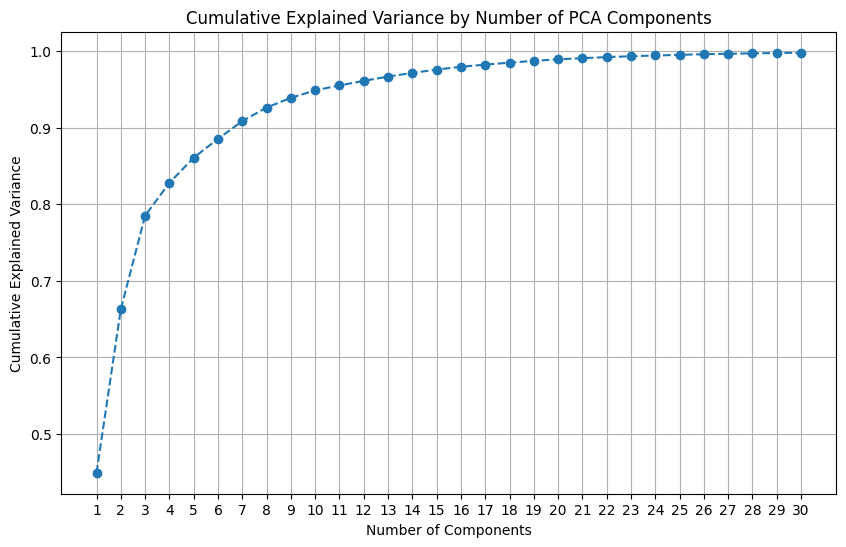

In [311]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X = df_oversampled.drop(columns=['highGrade'])
X_test= df_test.drop(columns=['highGrade']) # for testing later


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test) #for testing later


pca = PCA()
X_pca = pca.fit_transform(X_scaled)


explained_variance_ratio = pca.explained_variance_ratio_[:30]
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()


In [312]:
# escogemos 7 copmponentes

n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])


df_pca['highGrade'] = df_oversampled['highGrade'].reset_index(drop=True)

df_pca['Id'] = df_oversampled.index
df_pca.set_index('Id', inplace=True)

print(df_pca.head())


               PC1       PC2       PC3       PC4  highGrade
Id                                                         
0.780639 -5.536504  4.045254  0.316387 -2.145713       True
0.598276  4.093460  2.134247 -1.023057  1.044241      False
0.729481 -5.687011  5.643167  0.693727 -2.330425       True
0.775903 -1.586211  0.782491 -1.835409 -1.473770      False
0.637506  1.675581  1.475474 -2.248183  1.335559       True


In [313]:
n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_test_scaled)

df_test_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_test_pca['highGrade'] = df_oversampled['highGrade'].reset_index(drop=True)

df_test_pca['Id'] = df_test.index
df_test_pca.set_index('Id', inplace=True)

print(df_test_pca.head())

                PC1       PC2       PC3       PC4  highGrade
Id                                                          
0.793785  -3.712394  0.044634 -1.658615 -0.655442       True
0.858519  -4.054439  1.639662  1.245764  2.139769      False
0.770150   5.930935  8.218212 -1.165593 -4.455024       True
0.678449   3.387031 -1.287753 -2.195853  2.485774      False
0.601364  11.081488  0.160963 -2.563952  2.026090       True


In [314]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Assuming df_pca contains your PCA-reduced data and 'highGrade' is your target
X = df_pca.drop(columns=['highGrade'])  # Exclude the target and Id columns
X_test = df_test_pca.drop(columns=['highGrade'])  # Exclude the target and Id columns
y = df_pca['highGrade']
y_test= df_test_pca['highGrade']



# Define the SVM model
svm = SVC()

# Set the range of parameters for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernels to test
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    'degree': [2, 3],  # Only used for 'poly' kernel
    'coef0': [0, 1]  # Only used for 'poly' and 'sigmoid'
}

# Set up the GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with the training data
grid_search.fit(X, y)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

# Print the best parameters
print("Best parameters from GridSearchCV:", best_params)


y_pred = best_svm.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_pred, y_test))



Best parameters from GridSearchCV: {'C': 10, 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00         1
        True       0.93      0.61      0.74        23

    accuracy                           0.58        24
   macro avg       0.47      0.30      0.37        24
weighted avg       0.89      0.58      0.71        24

